In [315]:
import numpy as np # numerical operations
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import pandas as pd # dataframe manipulation
from mpl_toolkits.basemap import Basemap # map plotting

sns.set(context='paper', style='ticks', font_scale=1) # set the plot style

The code below can be used to install the missing librariies in Google Colab. 

In [316]:
### Google Colab installations ###
# !pip install basemap

## 1. Replication of Winter et al. (2022)

### 1.1. Reading and cleaning the data

Let's start by reading the data:

In [317]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeykosh/intro-to-ling/main/S2/data/final_data_winter_2022.csv', 
                   sep=',', # type of separator in the data
                   header=0) # where the header is situated

Let's look at the data. What columns do you see? What does one row correspond to?

In [318]:
data.head(10)

,Language,ISO_code,Phoible_code,Meaning,Trill,Dataset,Latitude,Longitude,Family,Branch,Area,Continent,Rough.M,rough,R_type,r,l,Meaning.f
0,Azeerbaijani,aze,azj,‘rough’,no,Google,40.50,48.50,Turkic,Common Turkic,Greater Mesopotamia,W and SW Eurasia,6.2,True,no trill,False,False,‘rough’
1,Basque,eus,eus,‘rough’,yes,Google,43.00,-3.00,Basque,NaN,Europe,W and SW Eurasia,6.2,True,mixed with trill,True,False,‘rough’
2,Haitian Creole,hat,hat,‘rough’,no,Google,19.00,-72.50,Haitian Creole,NaN,Mesoamerica,C America,6.2,True,NaN,True,False,‘rough’
3,Hebrew,heb,heb,‘rough’,no,Google,31.50,34.83,Semitic,West Semitic,Greater Mesopotamia,W and SW Eurasia,6.2,True,no rhotic,False,False,‘rough’
4,Georgian,kat,kat,‘rough’,yes,Google,42.00,44.00,Kartvelian,Georgian-Zan,Greater Mesopotamia,W and SW Eurasia,6.2,True,trill,False,False,‘rough’
5,Mongolian,mon,khk,‘rough’,yes,Google,49.00,117.00,Mongolic,NaN,Inner Asia,N-C Asia,6.2,True,trill,True,False,‘rough’
6,Malay,mly,zsm,‘rough’,yes,Google,3.00,102.00,Austronesian,Malayo-Polynesian,Southeast Asia,S/SE Asia,6.2,True,trill,True,False,‘rough’
7,Maltese,mlt,mlt,‘rough’,yes,Google,35.92,14.42,Semitic,West Semitic,Europe,W and SW Eurasia,6.2,True,trill,False,False,‘rough’
8,Sundanese,sun,sun,‘rough’,no,Google,-7.00,107.00,Austronesian,Malayo-Polynesian,Southeast Asia,S/SE Asia,6.2,True,no trill,True,False,‘rough’
9,Tagalog (Filipino),tgl,tgl,‘rough’,no,Google,15.00,121.00,Austronesian,Malayo-Polynesian,Oceania,S/SE Asia,6.2,True,no trill,False,False,‘rough’


Let's look at the contents of the Trill column:

In [319]:
data.Trill.unique()

array(['no', 'yes'], dtype=object)

Let's count the number of languages with trills and without trills:

In [320]:
data.drop_duplicates(subset=['ISO_code'])['Trill'].value_counts()

Trill
yes    177
no     152
Name: count, dtype: int64

### 1.2. Map plotting

Let's create a separate dataframe with the languages and their corresponding coordinates:

In [321]:
languages = data[['ISO_code', 'Language', 'Latitude', 'Longitude', 'Trill']].drop_duplicates(subset=['ISO_code'])
languages.shape

(329, 5)

We can check whethe the data is correct by counting trill types:

In [322]:
languages['Trill'].value_counts()

Trill
yes    177
no     152
Name: count, dtype: int64

Let's get the longitude and latitude of the languages with trills and without trills separately:

In [323]:
x_trill = languages.loc[languages['Trill'] == 'yes', 'Longitude']
y_trill = languages.loc[languages['Trill'] == 'yes', 'Latitude']

x_other = languages.loc[languages['Trill'] == 'no', 'Longitude']
y_other = languages.loc[languages['Trill'] == 'no', 'Latitude']

Finally, we can plot the map based on what we learned at Session 1:

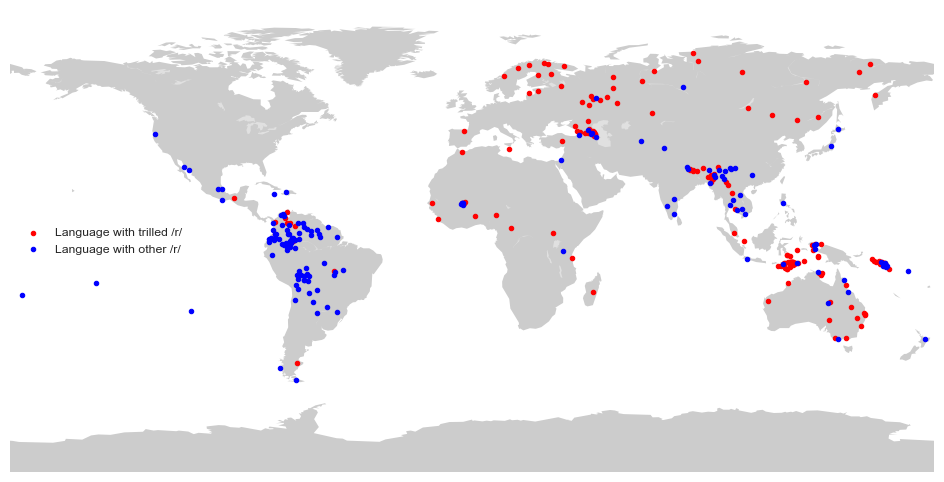

In [324]:
plt.figure(figsize=(12, 6))
m = Basemap(projection='cyl', # type of projection
            lat_0=0, # latitude of the map center
            lon_0=0, # longitude of the map center
            resolution='c') # low resolution (crude)
m.fillcontinents(color='gray', # color of the continents
                 lake_color='white', # color of the lakes
                 alpha=0.4) # transparency of the fill
m.scatter(x_trill, # longitudes
          y_trill, # latitudes
          latlon=True, # interpret x, y as longitude and latitude (with transformation, try `moll`)
          label='Language with trilled /r/', # label for the legend
          color='red', s=10) # color and size of the points
m.scatter(x_other, 
          y_other, 
          latlon=True,
          label='Language with other /r/', 
          color='blue', s=10)
plt.legend(frameon=False)
# remove map border (for aesthetic reasons)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show() # show the plot

### 1.3. Analysing languages with trills only

We will start by looking at languages that only have trilled /r/ sounds.

In [325]:
data_trill_only = data[data.Trill == 'yes']

Checking that the dataset is correct:

In [326]:
data_trill_only.head(10)

,Language,ISO_code,Phoible_code,Meaning,Trill,Dataset,Latitude,Longitude,Family,Branch,Area,Continent,Rough.M,rough,R_type,r,l,Meaning.f
1,Basque,eus,eus,‘rough’,yes,Google,43.000000,-3.000000,Basque,NaN,Europe,W and SW Eurasia,6.2,True,mixed with trill,True,False,‘rough’
4,Georgian,kat,kat,‘rough’,yes,Google,42.000000,44.000000,Kartvelian,Georgian-Zan,Greater Mesopotamia,W and SW Eurasia,6.2,True,trill,False,False,‘rough’
5,Mongolian,mon,khk,‘rough’,yes,Google,49.000000,117.000000,Mongolic,NaN,Inner Asia,N-C Asia,6.2,True,trill,True,False,‘rough’
6,Malay,mly,zsm,‘rough’,yes,Google,3.000000,102.000000,Austronesian,Malayo-Polynesian,Southeast Asia,S/SE Asia,6.2,True,trill,True,False,‘rough’
7,Maltese,mlt,mlt,‘rough’,yes,Google,35.920000,14.420000,Semitic,West Semitic,Europe,W and SW Eurasia,6.2,True,trill,False,False,‘rough’
12,Pitta-Pitta,pit,pit,‘rough’,yes,Chirila,-23.870327,139.675189,Pama-Nyungan,Karnic,S Australia,Australia,6.2,True,trill,True,False,‘rough’
14,Ritharrngu,rit,rit,‘rough’,yes,Chirila,-13.091347,136.038424,Pama-Nyungan,Yolngu,N Australia,Australia,6.2,True,trill,True,False,‘rough’
15,Woiwurrung,wyi,wyi,‘rough’,yes,Chirila,-37.642645,145.587996,Pama-Nyungan,Kulinic,S Australia,Australia,6.2,True,trill,False,True,‘rough’
16,Yugambeh,yub,yub,‘rough’,yes,Chirila,-28.437400,153.301000,Pama-Nyungan,Bandjalangic,S Australia,Australia,6.2,True,NaN,True,True,‘rough’
17,Buwandik,xbg,xbg,‘rough’,yes,Chirila,-37.692988,141.315638,Pama-Nyungan,Kulinic,S Australia,Australia,6.2,True,NaN,True,False,‘rough’


We need to count the average amount of /r/ per meaning type ('rough' or 'smooth') for each family. For that, we will be groupping the data by family and meaning type and then calculating the mean counts of /r/ sounds.

In [327]:
summary = data_trill_only.groupby(['Family', 'Meaning']).agg({'r': 'mean'}).reset_index()

Let's see what we got:

In [328]:
summary.head(10)

,Family,Meaning,r
0,Adamawa-Ubangi,‘rough’,0.800000
1,Adamawa-Ubangi,‘smooth’,0.090909
2,Arawakan,‘rough’,0.000000
3,Arawakan,‘smooth’,0.000000
4,Austroasiatic,‘rough’,0.625000
5,Austroasiatic,‘smooth’,0.000000
6,Austronesian,‘rough’,0.681818
7,Austronesian,‘smooth’,0.222222
8,Barbacoan,‘smooth’,0.000000
9,Basque,‘rough’,1.000000


We can convert the mean counts to percentages by multiplying them by 100:

In [329]:
summary['r'] = summary['r'] * 100

Let's look at some families:

In [330]:
summary.query('Family == "Turkic"')

,Family,Meaning,r
59,Turkic,‘rough’,33.333333
60,Turkic,‘smooth’,20.000000


Let's plot the results. First, we will start by plotting the swarmplot (a type of scatterplot) for the data. We will be using the seaborn [swarmplot function](https://seaborn.pydata.org/generated/seaborn.swarmplot.html) for that:

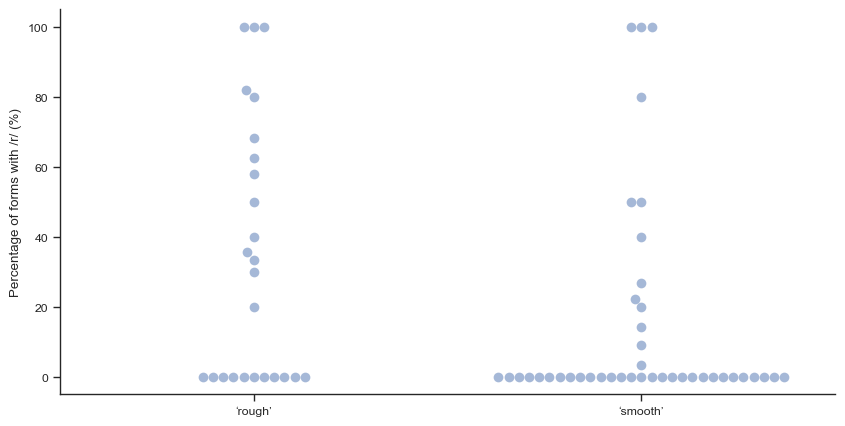

In [331]:
plt.figure(figsize=(10, 5)) # define the figure size
sns.swarmplot(data=summary, # data for the plot
              x='Meaning', # x-axis variable (type of meaning)
              y='r', # y-axis variable (percentage of forms with /r/)
              size = 7, # size of the points
              alpha=0.5) # transparency of the points
plt.xlabel(None) # remove the x-axis label
plt.ylabel('Percentage of forms with /r/ (%)') # set the y-axis label
sns.despine() # remove the top and right spines (just for aesthetics)
plt.show()

Now we can add the mean values to the plot with the confidence intervals. We will be using the seaborn [pointplot function](https://seaborn.pydata.org/generated/seaborn.pointplot.html) for that:

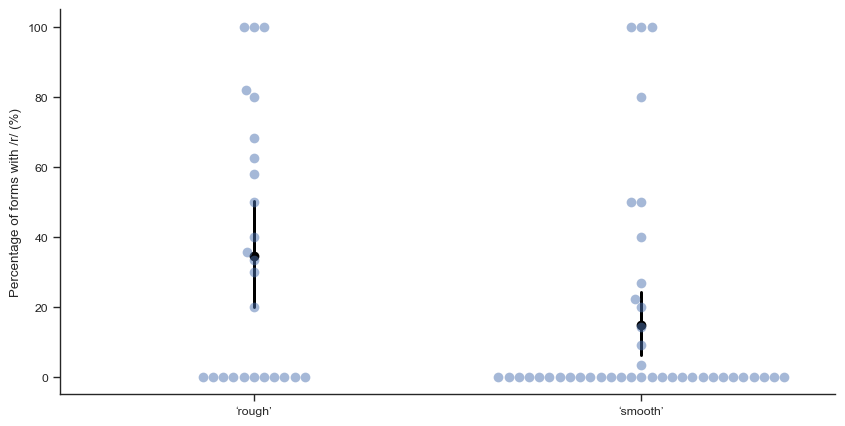

In [339]:
plt.figure(figsize=(10, 5)) # define the figure size
sns.swarmplot(data=summary, # data for the plot
              x='Meaning', # x-axis variable (type of meaning)
              y='r', # y-axis variable (percentage of forms with /r/)
              size = 7, # size of the points
              alpha=0.5) # transparency of the points
sns.pointplot(data=summary, # data for the plot
              x='Meaning',  # x-axis variable (type of meaning)
              y='r',  # y-axis variable (percentage of forms with /r/)
              estimator=np.mean, # function to estimate the central point (mean)
              color='black', # color 
              linestyle='none', # no line connecting the points
              errorbar=('ci', 95)) # error bars (95% confidence interval)
plt.xlabel(None) # remove the x-axis label
plt.ylabel('Percentage of forms with /r/ (%)') # set the y-axis label
sns.despine() # remove the top and right spines (just for aesthetics)
plt.show()

Great, we just reproduced Figure 3 from Winter et al. (2022)! However, it seems that there is a caweat in how they are plotting the data... Let's look at it again, do you see something weird?

In [341]:
summary.head(10)

,Family,Meaning,r
0,Adamawa-Ubangi,‘rough’,80.000000
1,Adamawa-Ubangi,‘smooth’,9.090909
2,Arawakan,‘rough’,0.000000
3,Arawakan,‘smooth’,0.000000
4,Austroasiatic,‘rough’,62.500000
5,Austroasiatic,‘smooth’,0.000000
6,Austronesian,‘rough’,68.181818
7,Austronesian,‘smooth’,22.222222
8,Barbacoan,‘smooth’,0.000000
9,Basque,‘rough’,100.000000


Let's look at the Barbacoan family (languages which are spoken in Colombia and Ecuador):

In [343]:
summary.query('Family == "Barbacoan"')

,Family,Meaning,r
8,Barbacoan,‘smooth’,0.0


There is ony one entry for this family ('smooth'), so we can't really say anything about it. We need to adjust it by adding a new entry. for the absence of trills.

In [344]:
def add_absenses(data):
    for Family in data.Family.unique(): # for each family in the dataset
        if len(data[data.Family == Family]) == 1: # if only one entry is present
            if "‘smooth’" in data[data.Family == Family].Meaning.values: # if the meaning is 'smooth' 
                new_entry = pd.DataFrame({'Family': [Family], 'Meaning': ["‘rough’"], 'r': [0]}) # add absence of 'rough'
            else: # if the meaning is 'rough'
                new_entry = pd.DataFrame({'Family': [Family], 'Meaning': ["‘smooth’"], 'r': [0]}) # add absence of 'smooth'
            data = pd.concat([data, new_entry], ignore_index=True)

    return data

In [345]:
summary_w_absences = add_absenses(summary)

In [346]:
summary_w_absences[summary_w_absences['Family'] == 'Barbacoan']

,Family,Meaning,r
8,Barbacoan,‘smooth’,0.0
67,Barbacoan,‘rough’,0.0


Let's reporduce the plot from above with the new data:

In [348]:
## YOUR CODE HERE ###

### 1.4. Analysing languages with different types of /r/

We haven't looked at the languages with different types of /r/ sounds yet. Let's start by looking at the data for languages with other types of /r/ sounds:

In [350]:
data_other_type = data[data.Trill == 'no']

Now it's your turn, you need to recreate the same analysis as before, just for this new subset.

In [351]:
### YOUR ANSWER HERE ###